## Use the right version of TensorFlow



The following hidden code cell ensures that the Colab will run on TensorFlow 2.X.

In [1]:
# @title Run on TensorFlow 2.x
# %tensorflow_version 2.x

## Call the import statements

The following code imports the necessary modules.

In [2]:
#@title Load the imports

# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from time import time
# from sklearn.preprocessing import MaxAbsScaler

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

ModuleNotFoundError: No module named 'tensorflow'

## Load the datasets 

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [3]:
train_df = pd.read_csv("Dataset/training/fsi-2006-to-2013.csv")
test_df = pd.read_csv("Dataset/testing/fsi-2014-to2020.csv")
train_df.dtypes
del train_df['Country']
del train_df['Rank']

del test_df['Country']
del test_df['Rank']

In [4]:
train_df['Total'] = train_df['Total']/10

def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
#         print(column.dtype)
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm
train_df_norm = min_max_scaling(train_df)
    
# call the min_max_scaling function
# df_cars_normalized = min_max_scaling(df_cars)
# train_df_mean = train_df.mean()
# train_df_std = train_df.std()
# train_df_norm = (train_df - train_df_mean)/train_df_std
# train_df_norm.head()
# train_df.dtypes
# train_df.memory_usage(deep=True)

In [5]:

test_df['Total'] = test_df['Total']/10
test_df_norm = min_max_scaling(test_df)
# test_df_mean = test_df.mean()
# test_df_std  = test_df.std()
# test_df_norm = (test_df - test_df_mean)/test_df_std
test_df_norm.head()

,Year,Total,Security_Apparatus,Factionalized_Elites,Group_Grievance,Economy,Economic_Inequality,Human_Flight_and_Brain_Drain,State_Legitimacy,Public_Services,Human_Rights,Demographic_Pressures,Refugees_and_IDPs,External_Intervention,Change_from_Previous_Year
0,1.0,1.0,1.0,1.0,1.0,0.9,0.8,0.7,1.0,0.9,1.0,1.0,1.0,1.0,0.5
1,1.0,1.0,1.0,1.0,0.8,0.9,0.9,0.9,0.9,0.9,0.9,1.0,0.9,0.9,0.4
2,1.0,1.0,0.9,1.0,0.9,0.9,0.9,0.7,1.0,0.9,0.9,0.9,1.0,0.9,0.4
3,1.0,1.0,1.0,1.0,1.0,0.9,0.7,0.8,1.0,0.9,1.0,0.7,1.0,1.0,0.5
4,1.0,0.9,0.8,1.0,1.0,0.8,0.9,0.7,1.0,0.9,0.9,1.0,1.0,0.9,0.5


In [6]:
# train_df.corr()
# train_df.info()
train_df_norm.describe( )

,Year,Total,Security_Apparatus,Factionalized_Elites,Group_Grievance,Economy,Economic_Inequality,Human_Flight_and_Brain_Drain,State_Legitimacy,Public_Services,Human_Rights,Demographic_Pressures,Refugees_and_IDPs,External_Intervention
count,1387.0,1387.0,1387.0,1387.0,1387.0,1387.0,1387.0,1387.0,1387.0,1387.0,1387.0,1387.0,1387.0,1387.0
mean,0.5,0.6,0.5,0.6,0.6,0.5,0.7,0.5,0.6,0.5,0.5,0.6,0.5,0.5
std,0.3,0.2,0.3,0.3,0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.2,0.3,0.2
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.3,0.4,0.4,0.4,0.4,0.4,0.5,0.4,0.5,0.3,0.4,0.4,0.3,0.4
50%,0.6,0.6,0.6,0.7,0.6,0.5,0.7,0.6,0.7,0.6,0.6,0.6,0.5,0.6
75%,0.9,0.7,0.7,0.8,0.7,0.7,0.8,0.7,0.8,0.8,0.7,0.8,0.6,0.7
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [7]:
#@title Double-click for possible solutions.

# We arbitrarily set the threshold to 265,000, which is 
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1, 
# and all other neighborhoods will be labeled 0.
threshold = 9
train_df_norm["median_house_value_is_high"] = (train_df["Total"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["Total"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)


# Alternatively, instead of picking the threshold
# based on raw house values, you can work with Z-scores.
# For example, the following possible solution uses a Z-score
# of +1.0 as the threshold, meaning that no more
# than 16% of the values in median_house_value_is_high
# will be labeled 1.

# threshold_in_Z = 1.0 
# train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)
# test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float) 


0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
        ..
1382   0.0
1383   0.0
1384   0.0
1385   0.0
1386   0.0
Name: median_house_value_is_high, Length: 1387, dtype: float64

## Represent features in feature columns

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 

In [8]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
all_features = ['Security_Apparatus','Factionalized_Elites','Group_Grievance','Economy',
                'Economic_Inequality','Human_Flight_and_Brain_Drain','State_Legitimacy',
                'Public_Services','Human_Rights','Demographic_Pressures','Refugees_and_IDPs',
                'External_Intervention']
for f in all_features:
  x=tf.feature_column.numeric_column(f)
  feature_columns.append(x)
# median_income = tf.feature_column.numeric_column("Security_Apparatus")
# feature_columns.append(median_income)

# # Create a numerical feature column to represent total_rooms.
# tr = tf.feature_column.numeric_column("Factionalized_Elites")
# feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(1387, 12), dtype=float32, numpy=
array([[0.9456522 , 0.85057473, 0.93333334, ..., 1.        , 0.96703297,
        0.94736844],
       [1.        , 0.8965517 , 0.8333333 , ..., 1.        , 1.        ,
        0.95789474],
       [0.8695652 , 0.86206895, 0.75555557, ..., 1.        , 0.978022  ,
        0.95789474],
       ...,
       [0.23913044, 0.11494253, 0.13333334, ..., 0.06593407, 0.01098901,
        0.05263158],
       [0.23913044, 0.11494253, 0.02222222, ..., 0.17582418, 0.01098901,
        0.05263158],
       [0.23913044, 0.11494253, 0.08888889, ..., 0.06593407, 0.01098901,
        0.05263158]], dtype=float32)>

## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(my_learning_rate, feature_layer, my_metrics)`, which defines the model's
    topography.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Prior exercises used [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) as the [activation function](https://developers.google.com/machine-learning/glossary#activation_function). By contrast, this exercise uses [sigmoid](https://developers.google.com/machine-learning/glossary#sigmoid_function) as the activation function. 

In [9]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)).astype('float64')
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


## Define a plotting function

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) function plots one or more curves, showing how various classification metrics change with each epoch.

In [10]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


## Invoke the creating, training, and plotting functions

The following code cell calls specify the hyperparameters, and then invokes the 
functions to create and train the model, and then to plot the results.

Model Builing 0.0071413516998291016 sec
Epoch 1/2000
Consider rewriting this model with the Functional API.


/home/vedant/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Consider rewriting this model with the Functional API.
28/28 [==============================] - 0s 1ms/step - loss: 0.6066 - accuracy: 0.6676
Epoch 2/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.5714 - accuracy: 0.7823
Epoch 3/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.5413 - accuracy: 0.7931
Epoch 4/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.5136 - accuracy: 0.7931
Epoch 5/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.4874 - accuracy: 0.8003
Epoch 6/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.4659 - accuracy: 0.8017
Epoch 7/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.4447 - accuracy: 0.8183
Epoch 8/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.8349
Epoch 9/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.4067 - accuracy: 0.8688
Epoch 10/2000
28/28 [==============================] - 0s 

28/28 [==============================] - 0s 1ms/step - loss: 0.1705 - accuracy: 0.9575
Epoch 70/2000
28/28 [==============================] - 0s 926us/step - loss: 0.1690 - accuracy: 0.9567
Epoch 71/2000
28/28 [==============================] - 0s 963us/step - loss: 0.1687 - accuracy: 0.9503
Epoch 72/2000
28/28 [==============================] - 0s 962us/step - loss: 0.1672 - accuracy: 0.9539
Epoch 73/2000
28/28 [==============================] - 0s 956us/step - loss: 0.1666 - accuracy: 0.9553
Epoch 74/2000
28/28 [==============================] - 0s 971us/step - loss: 0.1651 - accuracy: 0.9567
Epoch 75/2000
28/28 [==============================] - 0s 960us/step - loss: 0.1651 - accuracy: 0.9567
Epoch 76/2000
28/28 [==============================] - 0s 941us/step - loss: 0.1638 - accuracy: 0.9582
Epoch 77/2000
28/28 [==============================] - 0s 960us/step - loss: 0.1624 - accuracy: 0.9531
Epoch 78/2000
28/28 [==============================] - 0s 967us/step - loss: 0.1616 - acc

28/28 [==============================] - 0s 1ms/step - loss: 0.1212 - accuracy: 0.9632
Epoch 150/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1207 - accuracy: 0.9690
Epoch 151/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1203 - accuracy: 0.9704
Epoch 152/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1202 - accuracy: 0.9661
Epoch 153/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1198 - accuracy: 0.9704
Epoch 154/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1197 - accuracy: 0.9647
Epoch 155/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1193 - accuracy: 0.9690
Epoch 156/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1191 - accuracy: 0.9676
Epoch 157/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1176 - accuracy: 0.9690
Epoch 158/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1182 - accuracy: 0.

28/28 [==============================] - 0s 1ms/step - loss: 0.0984 - accuracy: 0.9733
Epoch 230/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0985 - accuracy: 0.9755
Epoch 231/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0982 - accuracy: 0.9733
Epoch 232/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0981 - accuracy: 0.9719
Epoch 233/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9776
Epoch 234/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0975 - accuracy: 0.9769
Epoch 235/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0975 - accuracy: 0.9755
Epoch 236/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.9740
Epoch 237/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9755
Epoch 238/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0966 - accuracy: 0.

28/28 [==============================] - 0s 968us/step - loss: 0.0853 - accuracy: 0.9820
Epoch 310/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0848 - accuracy: 0.9776
Epoch 311/2000
28/28 [==============================] - 0s 1000us/step - loss: 0.0849 - accuracy: 0.9784
Epoch 312/2000
28/28 [==============================] - 0s 971us/step - loss: 0.0851 - accuracy: 0.9791
Epoch 313/2000
28/28 [==============================] - 0s 997us/step - loss: 0.0849 - accuracy: 0.9813
Epoch 314/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0848 - accuracy: 0.9769
Epoch 315/2000
28/28 [==============================] - 0s 894us/step - loss: 0.0846 - accuracy: 0.9798
Epoch 316/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0845 - accuracy: 0.9798
Epoch 317/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0842 - accuracy: 0.9798
Epoch 318/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0835 - a

28/28 [==============================] - 0s 1ms/step - loss: 0.0762 - accuracy: 0.9834
Epoch 389/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0766 - accuracy: 0.9834
Epoch 390/2000
28/28 [==============================] - 0s 937us/step - loss: 0.0759 - accuracy: 0.9849
Epoch 391/2000
28/28 [==============================] - 0s 983us/step - loss: 0.0763 - accuracy: 0.9813
Epoch 392/2000
28/28 [==============================] - 0s 969us/step - loss: 0.0759 - accuracy: 0.9827
Epoch 393/2000
28/28 [==============================] - 0s 931us/step - loss: 0.0765 - accuracy: 0.9827
Epoch 394/2000
28/28 [==============================] - 0s 920us/step - loss: 0.0759 - accuracy: 0.9827
Epoch 395/2000
28/28 [==============================] - 0s 965us/step - loss: 0.0758 - accuracy: 0.9813
Epoch 396/2000
28/28 [==============================] - 0s 961us/step - loss: 0.0758 - accuracy: 0.9813
Epoch 397/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0757 

28/28 [==============================] - 0s 901us/step - loss: 0.0702 - accuracy: 0.9849
Epoch 468/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0701 - accuracy: 0.9820
Epoch 469/2000
28/28 [==============================] - 0s 935us/step - loss: 0.0698 - accuracy: 0.9849
Epoch 470/2000
28/28 [==============================] - 0s 928us/step - loss: 0.0699 - accuracy: 0.9813
Epoch 471/2000
28/28 [==============================] - 0s 917us/step - loss: 0.0700 - accuracy: 0.9827
Epoch 472/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0694 - accuracy: 0.9841
Epoch 473/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0701 - accuracy: 0.9805
Epoch 474/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0689 - accuracy: 0.9856
Epoch 475/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0691 - accuracy: 0.9820
Epoch 476/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0696 - accu

28/28 [==============================] - 0s 1ms/step - loss: 0.0650 - accuracy: 0.9841
Epoch 548/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0647 - accuracy: 0.9863
Epoch 549/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0651 - accuracy: 0.9827
Epoch 550/2000
28/28 [==============================] - 0s 947us/step - loss: 0.0647 - accuracy: 0.9834
Epoch 551/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0648 - accuracy: 0.9834
Epoch 552/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0649 - accuracy: 0.9863
Epoch 553/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0648 - accuracy: 0.9856
Epoch 554/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0648 - accuracy: 0.9849
Epoch 555/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.9863
Epoch 556/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 

28/28 [==============================] - 0s 945us/step - loss: 0.0610 - accuracy: 0.9841
Epoch 628/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0609 - accuracy: 0.9863
Epoch 629/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0607 - accuracy: 0.9863
Epoch 630/2000
28/28 [==============================] - 0s 988us/step - loss: 0.0610 - accuracy: 0.9856
Epoch 631/2000
28/28 [==============================] - 0s 976us/step - loss: 0.0601 - accuracy: 0.9856
Epoch 632/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0608 - accuracy: 0.9841
Epoch 633/2000
28/28 [==============================] - 0s 961us/step - loss: 0.0608 - accuracy: 0.9841
Epoch 634/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0603 - accuracy: 0.9841
Epoch 635/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0602 - accuracy: 0.9877
Epoch 636/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0606 - accu

28/28 [==============================] - 0s 1ms/step - loss: 0.0573 - accuracy: 0.9877
Epoch 708/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0580 - accuracy: 0.9870
Epoch 709/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0579 - accuracy: 0.9870
Epoch 710/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0572 - accuracy: 0.9870
Epoch 711/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0576 - accuracy: 0.9841
Epoch 712/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0574 - accuracy: 0.9899
Epoch 713/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0576 - accuracy: 0.9885
Epoch 714/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0573 - accuracy: 0.9885
Epoch 715/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0574 - accuracy: 0.9841
Epoch 716/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0574 - accuracy: 0.

28/28 [==============================] - 0s 933us/step - loss: 0.0551 - accuracy: 0.9877
Epoch 788/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0549 - accuracy: 0.9892
Epoch 789/2000
28/28 [==============================] - 0s 935us/step - loss: 0.0548 - accuracy: 0.9899
Epoch 790/2000
28/28 [==============================] - 0s 991us/step - loss: 0.0551 - accuracy: 0.9856
Epoch 791/2000
28/28 [==============================] - 0s 959us/step - loss: 0.0546 - accuracy: 0.9863
Epoch 792/2000
28/28 [==============================] - 0s 948us/step - loss: 0.0546 - accuracy: 0.9892
Epoch 793/2000
28/28 [==============================] - 0s 990us/step - loss: 0.0549 - accuracy: 0.9885
Epoch 794/2000
28/28 [==============================] - 0s 996us/step - loss: 0.0539 - accuracy: 0.9892
Epoch 795/2000
28/28 [==============================] - 0s 911us/step - loss: 0.0549 - accuracy: 0.9885
Epoch 796/2000
28/28 [==============================] - 0s 934us/step - loss: 0.0

28/28 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.9885
Epoch 868/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0519 - accuracy: 0.9892
Epoch 869/2000
28/28 [==============================] - 0s 2ms/step - loss: 0.0526 - accuracy: 0.9892
Epoch 870/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0527 - accuracy: 0.9906
Epoch 871/2000
28/28 [==============================] - 0s 936us/step - loss: 0.0522 - accuracy: 0.9885
Epoch 872/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0527 - accuracy: 0.9892
Epoch 873/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0522 - accuracy: 0.9892
Epoch 874/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0523 - accuracy: 0.9870
Epoch 875/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0521 - accuracy: 0.9892
Epoch 876/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 

28/28 [==============================] - 0s 943us/step - loss: 0.0505 - accuracy: 0.9899
Epoch 948/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0503 - accuracy: 0.9899
Epoch 949/2000
28/28 [==============================] - 0s 996us/step - loss: 0.0503 - accuracy: 0.9885
Epoch 950/2000
28/28 [==============================] - 0s 977us/step - loss: 0.0502 - accuracy: 0.9885
Epoch 951/2000
28/28 [==============================] - 0s 974us/step - loss: 0.0501 - accuracy: 0.9892
Epoch 952/2000
28/28 [==============================] - 0s 990us/step - loss: 0.0504 - accuracy: 0.9899
Epoch 953/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0504 - accuracy: 0.9899
Epoch 954/2000
28/28 [==============================] - 0s 971us/step - loss: 0.0500 - accuracy: 0.9906
Epoch 955/2000
28/28 [==============================] - 0s 956us/step - loss: 0.0504 - accuracy: 0.9899
Epoch 956/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0502 

28/28 [==============================] - 0s 998us/step - loss: 0.0488 - accuracy: 0.9892
Epoch 1027/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0487 - accuracy: 0.9906
Epoch 1028/2000
28/28 [==============================] - 0s 944us/step - loss: 0.0486 - accuracy: 0.9899
Epoch 1029/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0487 - accuracy: 0.9899
Epoch 1030/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0485 - accuracy: 0.9906
Epoch 1031/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0483 - accuracy: 0.9892
Epoch 1032/2000
28/28 [==============================] - 0s 1000us/step - loss: 0.0487 - accuracy: 0.9899
Epoch 1033/2000
28/28 [==============================] - 0s 968us/step - loss: 0.0483 - accuracy: 0.9906
Epoch 1034/2000
28/28 [==============================] - 0s 982us/step - loss: 0.0486 - accuracy: 0.9870
Epoch 1035/2000
28/28 [==============================] - 0s 964us/step - loss:

28/28 [==============================] - 0s 1ms/step - loss: 0.0470 - accuracy: 0.9928
Epoch 1105/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0470 - accuracy: 0.9899
Epoch 1106/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0471 - accuracy: 0.9906
Epoch 1107/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0472 - accuracy: 0.9921
Epoch 1108/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0470 - accuracy: 0.9906
Epoch 1109/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0471 - accuracy: 0.9899
Epoch 1110/2000
28/28 [==============================] - 0s 964us/step - loss: 0.0469 - accuracy: 0.9892
Epoch 1111/2000
28/28 [==============================] - 0s 961us/step - loss: 0.0470 - accuracy: 0.9899
Epoch 1112/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0469 - accuracy: 0.9913
Epoch 1113/2000
28/28 [==============================] - 0s 963us/step - loss: 0.0472

28/28 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9928
Epoch 1184/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0456 - accuracy: 0.9870
Epoch 1185/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9899
Epoch 1186/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0456 - accuracy: 0.9906
Epoch 1187/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0456 - accuracy: 0.9906
Epoch 1188/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9921
Epoch 1189/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0457 - accuracy: 0.9892
Epoch 1190/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0454 - accuracy: 0.9906
Epoch 1191/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0455 - accuracy: 0.9899
Epoch 1192/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0454 - acc

28/28 [==============================] - 0s 1ms/step - loss: 0.0447 - accuracy: 0.9906
Epoch 1263/2000
28/28 [==============================] - 0s 925us/step - loss: 0.0439 - accuracy: 0.9906
Epoch 1264/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0443 - accuracy: 0.9913
Epoch 1265/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0444 - accuracy: 0.9906
Epoch 1266/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0444 - accuracy: 0.9906
Epoch 1267/2000
28/28 [==============================] - 0s 994us/step - loss: 0.0437 - accuracy: 0.9935
Epoch 1268/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0442 - accuracy: 0.9885
Epoch 1269/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0441 - accuracy: 0.9899
Epoch 1270/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0443 - accuracy: 0.9906
Epoch 1271/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0441 -

28/28 [==============================] - 0s 1ms/step - loss: 0.0427 - accuracy: 0.9899
Epoch 1342/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0431 - accuracy: 0.9899
Epoch 1343/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0432 - accuracy: 0.9899
Epoch 1344/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0431 - accuracy: 0.9906
Epoch 1345/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0431 - accuracy: 0.9913
Epoch 1346/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0428 - accuracy: 0.9892
Epoch 1347/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0429 - accuracy: 0.9935
Epoch 1348/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0432 - accuracy: 0.9906
Epoch 1349/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0427 - accuracy: 0.9913
Epoch 1350/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0429 - acc

28/28 [==============================] - 0s 1ms/step - loss: 0.0420 - accuracy: 0.9892
Epoch 1421/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0419 - accuracy: 0.9906
Epoch 1422/2000
28/28 [==============================] - 0s 1000us/step - loss: 0.0419 - accuracy: 0.9913
Epoch 1423/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0414 - accuracy: 0.9921
Epoch 1424/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0417 - accuracy: 0.9906
Epoch 1425/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0421 - accuracy: 0.9913
Epoch 1426/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0417 - accuracy: 0.9899
Epoch 1427/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0421 - accuracy: 0.9921
Epoch 1428/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0420 - accuracy: 0.9906
Epoch 1429/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0418 - 

28/28 [==============================] - 0s 1ms/step - loss: 0.0407 - accuracy: 0.9913
Epoch 1500/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0407 - accuracy: 0.9921
Epoch 1501/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0410 - accuracy: 0.9928
Epoch 1502/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0409 - accuracy: 0.9913
Epoch 1503/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0409 - accuracy: 0.9906
Epoch 1504/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0409 - accuracy: 0.9921
Epoch 1505/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0405 - accuracy: 0.9899
Epoch 1506/2000
28/28 [==============================] - 0s 994us/step - loss: 0.0408 - accuracy: 0.9885
Epoch 1507/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0407 - accuracy: 0.9913
Epoch 1508/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0402 - a

28/28 [==============================] - 0s 1ms/step - loss: 0.0401 - accuracy: 0.9921
Epoch 1579/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0402 - accuracy: 0.9906
Epoch 1580/2000
28/28 [==============================] - 0s 887us/step - loss: 0.0400 - accuracy: 0.9928
Epoch 1581/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0399 - accuracy: 0.9899
Epoch 1582/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0396 - accuracy: 0.9942
Epoch 1583/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0401 - accuracy: 0.9928
Epoch 1584/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0400 - accuracy: 0.9913
Epoch 1585/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0395 - accuracy: 0.9899
Epoch 1586/2000
28/28 [==============================] - 0s 956us/step - loss: 0.0398 - accuracy: 0.9913
Epoch 1587/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0400 -

28/28 [==============================] - 0s 1ms/step - loss: 0.0390 - accuracy: 0.9913
Epoch 1658/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0391 - accuracy: 0.9928
Epoch 1659/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0389 - accuracy: 0.9921
Epoch 1660/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0387 - accuracy: 0.9935
Epoch 1661/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0390 - accuracy: 0.9928
Epoch 1662/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0391 - accuracy: 0.9913
Epoch 1663/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0393 - accuracy: 0.9913
Epoch 1664/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0389 - accuracy: 0.9921
Epoch 1665/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0387 - accuracy: 0.9942
Epoch 1666/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0392 - acc

28/28 [==============================] - 0s 1ms/step - loss: 0.0382 - accuracy: 0.9913
Epoch 1737/2000
28/28 [==============================] - 0s 993us/step - loss: 0.0380 - accuracy: 0.9942
Epoch 1738/2000
28/28 [==============================] - 0s 953us/step - loss: 0.0379 - accuracy: 0.9913
Epoch 1739/2000
28/28 [==============================] - 0s 980us/step - loss: 0.0385 - accuracy: 0.9921
Epoch 1740/2000
28/28 [==============================] - 0s 950us/step - loss: 0.0381 - accuracy: 0.9913
Epoch 1741/2000
28/28 [==============================] - 0s 995us/step - loss: 0.0381 - accuracy: 0.9913
Epoch 1742/2000
28/28 [==============================] - 0s 959us/step - loss: 0.0383 - accuracy: 0.9928
Epoch 1743/2000
28/28 [==============================] - 0s 990us/step - loss: 0.0382 - accuracy: 0.9913
Epoch 1744/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0384 - accuracy: 0.9899
Epoch 1745/2000
28/28 [==============================] - 0s 977us/step - lo

Epoch 1815/2000
28/28 [==============================] - 0s 997us/step - loss: 0.0376 - accuracy: 0.9935
Epoch 1816/2000
28/28 [==============================] - 0s 983us/step - loss: 0.0374 - accuracy: 0.9928
Epoch 1817/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0374 - accuracy: 0.9913
Epoch 1818/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0372 - accuracy: 0.9928
Epoch 1819/2000
28/28 [==============================] - 0s 983us/step - loss: 0.0376 - accuracy: 0.9913
Epoch 1820/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0376 - accuracy: 0.9928
Epoch 1821/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0374 - accuracy: 0.9935
Epoch 1822/2000
28/28 [==============================] - 0s 990us/step - loss: 0.0375 - accuracy: 0.9913
Epoch 1823/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.0373 - accuracy: 0.9921
Epoch 1824/2000
28/28 [==============================] - 0s 995us

Epoch 1893/2000
28/28 [==============================] - 0s 853us/step - loss: 0.0366 - accuracy: 0.9935
Epoch 1894/2000
28/28 [==============================] - 0s 828us/step - loss: 0.0367 - accuracy: 0.9935
Epoch 1895/2000
28/28 [==============================] - 0s 788us/step - loss: 0.0368 - accuracy: 0.9928
Epoch 1896/2000
28/28 [==============================] - 0s 810us/step - loss: 0.0366 - accuracy: 0.9913
Epoch 1897/2000
28/28 [==============================] - 0s 878us/step - loss: 0.0369 - accuracy: 0.9921
Epoch 1898/2000
28/28 [==============================] - 0s 852us/step - loss: 0.0365 - accuracy: 0.9935
Epoch 1899/2000
28/28 [==============================] - 0s 859us/step - loss: 0.0368 - accuracy: 0.9921
Epoch 1900/2000
28/28 [==============================] - 0s 852us/step - loss: 0.0366 - accuracy: 0.9928
Epoch 1901/2000
28/28 [==============================] - 0s 831us/step - loss: 0.0367 - accuracy: 0.9921
Epoch 1902/2000
28/28 [==============================] 

28/28 [==============================] - 0s 993us/step - loss: 0.0359 - accuracy: 0.9906
Epoch 1972/2000
28/28 [==============================] - 0s 942us/step - loss: 0.0357 - accuracy: 0.9935
Epoch 1973/2000
28/28 [==============================] - 0s 892us/step - loss: 0.0359 - accuracy: 0.9928
Epoch 1974/2000
28/28 [==============================] - 0s 887us/step - loss: 0.0360 - accuracy: 0.9913
Epoch 1975/2000
28/28 [==============================] - 0s 865us/step - loss: 0.0360 - accuracy: 0.9935
Epoch 1976/2000
28/28 [==============================] - 0s 887us/step - loss: 0.0361 - accuracy: 0.9928
Epoch 1977/2000
28/28 [==============================] - 0s 892us/step - loss: 0.0362 - accuracy: 0.9921
Epoch 1978/2000
28/28 [==============================] - 0s 886us/step - loss: 0.0361 - accuracy: 0.9942
Epoch 1979/2000
28/28 [==============================] - 0s 892us/step - loss: 0.0359 - accuracy: 0.9935
Epoch 1980/2000
28/28 [==============================] - 0s 995us/step 

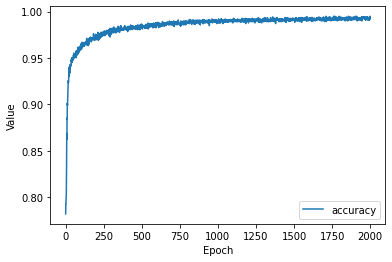

In [11]:
# The following variables are the hyperparameters.
from time import time

learning_rate = 0.01
epochs = 2000
batch_size = 50
label_name = "median_house_value_is_high"
classification_threshold = 0.4

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
st=time()
my_model = create_model(learning_rate, feature_layer, METRICS)
print("Model Builing",time()-st,'sec')
st=time()
# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)
print("Training with souly on accuracy",time()-st,'sec')
# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)
print('it took',time()-st,'sec')

Accuracy should gradually improve during training (until it can 
improve no more).

## Evaluate the model against the test set

At the end of model training, you ended up with a certain accuracy against the *training set*. Invoke the following code cell to determine your model's accuracy against the *test set*.

In [12]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
25/25 [==============================] - 0s 821us/step - loss: 0.0385 - accuracy: 0.9888


[0.0384579561650753, 0.9887640476226807]

## Add precision and recall as metrics

Relying solely on accuracy, particularly for a class-imbalanced data set (like ours), can be a poor way to judge a classification model.  Modify the code in the following code cell to enable the model to measure not only accuracy but also precision and recall. We have
added accuracy and precision; your task is to add recall. See the [TensorFlow Reference](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall) for details.



Epoch 1/2000
Consider rewriting this model with the Functional API.


/home/vedant/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Consider rewriting this model with the Functional API.
3/3 [==============================] - 1s 2ms/step - loss: 0.6951 - accuracy: 0.2242 - precision: 0.1947 - recall: 0.9377
Epoch 2/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.6267 - accuracy: 0.3691 - precision: 0.0899 - recall: 0.2418
Epoch 3/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.6066 - accuracy: 0.5479 - precision: 0.0028 - recall: 0.0037
Epoch 4/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.5977 - accuracy: 0.6352 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.5923 - accuracy: 0.6727 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.5887 - accuracy: 0.7159 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.5847 - accuracy: 0.7275 - precision: 0.0000e+00 - 

3/3 [==============================] - 0s 2ms/step - loss: 0.4194 - accuracy: 0.8609 - precision: 0.9348 - recall: 0.3150
Epoch 51/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.4157 - accuracy: 0.8529 - precision: 0.9367 - recall: 0.2711
Epoch 52/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.4130 - accuracy: 0.8601 - precision: 0.9247 - recall: 0.3150
Epoch 53/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.4101 - accuracy: 0.8745 - precision: 0.8779 - recall: 0.4212
Epoch 54/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.4080 - accuracy: 0.8702 - precision: 0.8720 - recall: 0.3993
Epoch 55/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.4049 - accuracy: 0.8673 - precision: 0.8803 - recall: 0.3773
Epoch 56/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.4025 - accuracy: 0.8702 - precision: 0.8780 - recall: 0.3956
Epoch 57/2000
3/3 [==============================] - 0s 2ms/st

3/3 [==============================] - 0s 2ms/step - loss: 0.3072 - accuracy: 0.9041 - precision: 0.7917 - recall: 0.6960
Epoch 111/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.3034 - accuracy: 0.9084 - precision: 0.7874 - recall: 0.7326
Epoch 112/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.3028 - accuracy: 0.9070 - precision: 0.7791 - recall: 0.7363
Epoch 113/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.3017 - accuracy: 0.9034 - precision: 0.7769 - recall: 0.7143
Epoch 114/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.3001 - accuracy: 0.9048 - precision: 0.7509 - recall: 0.7729
Epoch 115/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.3004 - accuracy: 0.9027 - precision: 0.7782 - recall: 0.7070
Epoch 116/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2983 - accuracy: 0.9077 - precision: 0.7695 - recall: 0.7582
Epoch 117/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.2505 - accuracy: 0.9149 - precision: 0.7758 - recall: 0.7985
Epoch 170/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2501 - accuracy: 0.9156 - precision: 0.7806 - recall: 0.7949
Epoch 171/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2490 - accuracy: 0.9193 - precision: 0.7885 - recall: 0.8059
Epoch 172/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.9164 - precision: 0.7679 - recall: 0.8242
Epoch 173/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.9185 - precision: 0.8008 - recall: 0.7802
Epoch 174/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2470 - accuracy: 0.9178 - precision: 0.7934 - recall: 0.7875
Epoch 175/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2462 - accuracy: 0.9178 - precision: 0.7849 - recall: 0.8022
Epoch 176/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.2172 - accuracy: 0.9315 - precision: 0.8504 - recall: 0.7912
Epoch 229/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2165 - accuracy: 0.9329 - precision: 0.8000 - recall: 0.8791
Epoch 230/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2160 - accuracy: 0.9366 - precision: 0.8439 - recall: 0.8315
Epoch 231/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2155 - accuracy: 0.9373 - precision: 0.8252 - recall: 0.8645
Epoch 232/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2150 - accuracy: 0.9366 - precision: 0.8413 - recall: 0.8352
Epoch 233/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2155 - accuracy: 0.9315 - precision: 0.8027 - recall: 0.8645
Epoch 234/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.2142 - accuracy: 0.9366 - precision: 0.8491 - recall: 0.8242
Epoch 235/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1943 - accuracy: 0.9452 - precision: 0.8530 - recall: 0.8718
Epoch 288/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1935 - accuracy: 0.9438 - precision: 0.8374 - recall: 0.8864
Epoch 289/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1940 - accuracy: 0.9423 - precision: 0.8434 - recall: 0.8681
Epoch 290/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1930 - accuracy: 0.9430 - precision: 0.8440 - recall: 0.8718
Epoch 291/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9430 - precision: 0.8514 - recall: 0.8608
Epoch 292/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1923 - accuracy: 0.9423 - precision: 0.8434 - recall: 0.8681
Epoch 293/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.1922 - accuracy: 0.9438 - precision: 0.8545 - recall: 0.8608
Epoch 294/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 3ms/step - loss: 0.1760 - accuracy: 0.9481 - precision: 0.8577 - recall: 0.8828
Epoch 347/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1757 - accuracy: 0.9495 - precision: 0.8773 - recall: 0.8645
Epoch 348/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1762 - accuracy: 0.9466 - precision: 0.8541 - recall: 0.8791
Epoch 349/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1755 - accuracy: 0.9481 - precision: 0.8551 - recall: 0.8864
Epoch 350/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1748 - accuracy: 0.9488 - precision: 0.8713 - recall: 0.8681
Epoch 351/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1748 - accuracy: 0.9488 - precision: 0.8659 - recall: 0.8755
Epoch 352/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.1743 - accuracy: 0.9488 - precision: 0.8556 - recall: 0.8901
Epoch 353/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1622 - accuracy: 0.9553 - precision: 0.8864 - recall: 0.8864
Epoch 406/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1616 - accuracy: 0.9510 - precision: 0.8571 - recall: 0.9011
Epoch 407/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1614 - accuracy: 0.9524 - precision: 0.8632 - recall: 0.9011
Epoch 408/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1616 - accuracy: 0.9517 - precision: 0.8679 - recall: 0.8901
Epoch 409/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1610 - accuracy: 0.9524 - precision: 0.8764 - recall: 0.8828
Epoch 410/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1607 - accuracy: 0.9539 - precision: 0.8719 - recall: 0.8974
Epoch 411/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.9539 - precision: 0.8719 - recall: 0.8974
Epoch 412/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1504 - accuracy: 0.9546 - precision: 0.8671 - recall: 0.9084
Epoch 465/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.1516 - accuracy: 0.9567 - precision: 0.8930 - recall: 0.8864
Epoch 466/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1501 - accuracy: 0.9575 - precision: 0.8794 - recall: 0.9084
Epoch 467/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1499 - accuracy: 0.9553 - precision: 0.8728 - recall: 0.9048
Epoch 468/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1500 - accuracy: 0.9546 - precision: 0.8697 - recall: 0.9048
Epoch 469/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9567 - precision: 0.8930 - recall: 0.8864
Epoch 470/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9546 - precision: 0.8671 - recall: 0.9084
Epoch 471/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1409 - accuracy: 0.9596 - precision: 0.8780 - recall: 0.9231
Epoch 524/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1414 - accuracy: 0.9567 - precision: 0.8763 - recall: 0.9084
Epoch 525/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1406 - accuracy: 0.9582 - precision: 0.8826 - recall: 0.9084
Epoch 526/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1405 - accuracy: 0.9603 - precision: 0.8785 - recall: 0.9267
Epoch 527/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1405 - accuracy: 0.9611 - precision: 0.8897 - recall: 0.9158
Epoch 528/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1404 - accuracy: 0.9603 - precision: 0.8865 - recall: 0.9158
Epoch 529/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.9603 - precision: 0.9007 - recall: 0.8974
Epoch 530/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1328 - accuracy: 0.9618 - precision: 0.8846 - recall: 0.9267
Epoch 583/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1329 - accuracy: 0.9611 - precision: 0.8789 - recall: 0.9304
Epoch 584/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.9632 - precision: 0.8993 - recall: 0.9158
Epoch 585/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1325 - accuracy: 0.9611 - precision: 0.8712 - recall: 0.9414
Epoch 586/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.9625 - precision: 0.8932 - recall: 0.9194
Epoch 587/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.9640 - precision: 0.9025 - recall: 0.9158
Epoch 588/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1320 - accuracy: 0.9611 - precision: 0.8815 - recall: 0.9267
Epoch 589/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9632 - precision: 0.8776 - recall: 0.9451
Epoch 642/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9654 - precision: 0.9032 - recall: 0.9231
Epoch 643/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1260 - accuracy: 0.9625 - precision: 0.8850 - recall: 0.9304
Epoch 644/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1255 - accuracy: 0.9647 - precision: 0.8916 - recall: 0.9341
Epoch 645/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1256 - accuracy: 0.9618 - precision: 0.8819 - recall: 0.9304
Epoch 646/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1253 - accuracy: 0.9640 - precision: 0.8885 - recall: 0.9341
Epoch 647/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1257 - accuracy: 0.9647 - precision: 0.8916 - recall: 0.9341
Epoch 648/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1198 - accuracy: 0.9618 - precision: 0.8846 - recall: 0.9267
Epoch 701/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1193 - accuracy: 0.9640 - precision: 0.8780 - recall: 0.9487
Epoch 702/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1192 - accuracy: 0.9640 - precision: 0.8805 - recall: 0.9451
Epoch 703/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1192 - accuracy: 0.9654 - precision: 0.8920 - recall: 0.9377
Epoch 704/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1191 - accuracy: 0.9647 - precision: 0.8810 - recall: 0.9487
Epoch 705/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1195 - accuracy: 0.9640 - precision: 0.8996 - recall: 0.9194
Epoch 706/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1190 - accuracy: 0.9654 - precision: 0.8893 - recall: 0.9414
Epoch 707/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1136 - accuracy: 0.9683 - precision: 0.9075 - recall: 0.9341
Epoch 760/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1135 - accuracy: 0.9690 - precision: 0.8938 - recall: 0.9560
Epoch 761/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.1139 - accuracy: 0.9683 - precision: 0.8881 - recall: 0.9597
Epoch 762/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1139 - accuracy: 0.9668 - precision: 0.9011 - recall: 0.9341
Epoch 763/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1134 - accuracy: 0.9647 - precision: 0.8862 - recall: 0.9414
Epoch 764/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1135 - accuracy: 0.9668 - precision: 0.8847 - recall: 0.9560
Epoch 765/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1132 - accuracy: 0.9676 - precision: 0.9043 - recall: 0.9341
Epoch 766/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9676 - precision: 0.9071 - recall: 0.9304
Epoch 819/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1089 - accuracy: 0.9712 - precision: 0.8976 - recall: 0.9634
Epoch 820/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1088 - accuracy: 0.9697 - precision: 0.8915 - recall: 0.9634
Epoch 821/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9690 - precision: 0.8993 - recall: 0.9487
Epoch 822/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1085 - accuracy: 0.9704 - precision: 0.9113 - recall: 0.9414
Epoch 823/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1085 - accuracy: 0.9683 - precision: 0.8881 - recall: 0.9597
Epoch 824/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1091 - accuracy: 0.9654 - precision: 0.8840 - recall: 0.9487
Epoch 825/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1046 - accuracy: 0.9719 - precision: 0.8900 - recall: 0.9780
Epoch 878/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1047 - accuracy: 0.9704 - precision: 0.9085 - recall: 0.9451
Epoch 879/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1043 - accuracy: 0.9719 - precision: 0.8926 - recall: 0.9744
Epoch 880/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1042 - accuracy: 0.9712 - precision: 0.9031 - recall: 0.9560
Epoch 881/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1041 - accuracy: 0.9712 - precision: 0.8949 - recall: 0.9670
Epoch 882/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1046 - accuracy: 0.9726 - precision: 0.9123 - recall: 0.9524
Epoch 883/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1040 - accuracy: 0.9719 - precision: 0.8953 - recall: 0.9707
Epoch 884/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.1003 - accuracy: 0.9740 - precision: 0.9017 - recall: 0.9744
Epoch 937/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1002 - accuracy: 0.9740 - precision: 0.9100 - recall: 0.9634
Epoch 938/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.1001 - accuracy: 0.9733 - precision: 0.8986 - recall: 0.9744
Epoch 939/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1000 - accuracy: 0.9726 - precision: 0.8956 - recall: 0.9744
Epoch 940/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1000 - accuracy: 0.9719 - precision: 0.9062 - recall: 0.9560
Epoch 941/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.1003 - accuracy: 0.9704 - precision: 0.9085 - recall: 0.9451
Epoch 942/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.1001 - accuracy: 0.9719 - precision: 0.8980 - recall: 0.9670
Epoch 943/2000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 2ms/step - loss: 0.0980 - accuracy: 0.9726 - precision: 0.9038 - recall: 0.9634
Epoch 996/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0968 - accuracy: 0.9740 - precision: 0.9044 - recall: 0.9707
Epoch 997/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.0970 - accuracy: 0.9755 - precision: 0.9051 - recall: 0.9780
Epoch 998/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.0973 - accuracy: 0.9755 - precision: 0.9051 - recall: 0.9780
Epoch 999/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0966 - accuracy: 0.9733 - precision: 0.9014 - recall: 0.9707
Epoch 1000/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.0966 - accuracy: 0.9740 - precision: 0.9017 - recall: 0.9744
Epoch 1001/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0967 - accuracy: 0.9755 - precision: 0.9193 - recall: 0.9597
Epoch 1002/2000
3/3 [==============================] -

3/3 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.9740 - precision: 0.8990 - recall: 0.9780
Epoch 1055/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0939 - accuracy: 0.9762 - precision: 0.9138 - recall: 0.9707
Epoch 1056/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0937 - accuracy: 0.9748 - precision: 0.9048 - recall: 0.9744
Epoch 1057/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0938 - accuracy: 0.9740 - precision: 0.9044 - recall: 0.9707
Epoch 1058/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0938 - accuracy: 0.9762 - precision: 0.9082 - recall: 0.9780
Epoch 1059/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0935 - accuracy: 0.9740 - precision: 0.9017 - recall: 0.9744
Epoch 1060/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0936 - accuracy: 0.9755 - precision: 0.9164 - recall: 0.9634
Epoch 1061/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0906 - accuracy: 0.9755 - precision: 0.9078 - recall: 0.9744
Epoch 1114/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.0907 - accuracy: 0.9748 - precision: 0.9048 - recall: 0.9744
Epoch 1115/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0909 - accuracy: 0.9769 - precision: 0.9170 - recall: 0.9707
Epoch 1116/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0909 - accuracy: 0.9791 - precision: 0.9326 - recall: 0.9634
Epoch 1117/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0914 - accuracy: 0.9748 - precision: 0.9020 - recall: 0.9780
Epoch 1118/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0905 - accuracy: 0.9776 - precision: 0.9172 - recall: 0.9744
Epoch 1119/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.9755 - precision: 0.9051 - recall: 0.9780
Epoch 1120/2000
3/3 [=============================

3/3 [==============================] - 0s 1ms/step - loss: 0.0882 - accuracy: 0.9762 - precision: 0.9110 - recall: 0.9744
Epoch 1173/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0881 - accuracy: 0.9784 - precision: 0.9204 - recall: 0.9744
Epoch 1174/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0884 - accuracy: 0.9769 - precision: 0.9199 - recall: 0.9670
Epoch 1175/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0881 - accuracy: 0.9755 - precision: 0.9024 - recall: 0.9817
Epoch 1176/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0882 - accuracy: 0.9776 - precision: 0.9172 - recall: 0.9744
Epoch 1177/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0881 - accuracy: 0.9805 - precision: 0.9331 - recall: 0.9707
Epoch 1178/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0883 - accuracy: 0.9776 - precision: 0.9172 - recall: 0.9744
Epoch 1179/2000
3/3 [=============================

3/3 [==============================] - 0s 1ms/step - loss: 0.0857 - accuracy: 0.9784 - precision: 0.9175 - recall: 0.9780
Epoch 1232/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0855 - accuracy: 0.9813 - precision: 0.9303 - recall: 0.9780
Epoch 1233/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0854 - accuracy: 0.9791 - precision: 0.9207 - recall: 0.9780
Epoch 1234/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0855 - accuracy: 0.9834 - precision: 0.9401 - recall: 0.9780
Epoch 1235/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0855 - accuracy: 0.9776 - precision: 0.9116 - recall: 0.9817
Epoch 1236/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0854 - accuracy: 0.9791 - precision: 0.9207 - recall: 0.9780
Epoch 1237/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0856 - accuracy: 0.9776 - precision: 0.9116 - recall: 0.9817
Epoch 1238/2000
3/3 [=============================

3/3 [==============================] - 0s 1ms/step - loss: 0.0835 - accuracy: 0.9805 - precision: 0.9301 - recall: 0.9744
Epoch 1291/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0836 - accuracy: 0.9798 - precision: 0.9268 - recall: 0.9744
Epoch 1292/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0832 - accuracy: 0.9791 - precision: 0.9207 - recall: 0.9780
Epoch 1293/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0839 - accuracy: 0.9784 - precision: 0.9233 - recall: 0.9707
Epoch 1294/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0834 - accuracy: 0.9791 - precision: 0.9207 - recall: 0.9780
Epoch 1295/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0832 - accuracy: 0.9798 - precision: 0.9239 - recall: 0.9780
Epoch 1296/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.9805 - precision: 0.9362 - recall: 0.9670
Epoch 1297/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0813 - accuracy: 0.9820 - precision: 0.9366 - recall: 0.9744
Epoch 1349/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0813 - accuracy: 0.9805 - precision: 0.9271 - recall: 0.9780
Epoch 1350/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9827 - precision: 0.9399 - recall: 0.9744
Epoch 1351/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.9784 - precision: 0.9175 - recall: 0.9780
Epoch 1352/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0810 - accuracy: 0.9813 - precision: 0.9333 - recall: 0.9744
Epoch 1353/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9805 - precision: 0.9362 - recall: 0.9670
Epoch 1354/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0817 - accuracy: 0.9805 - precision: 0.9241 - recall: 0.9817
Epoch 1355/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0794 - accuracy: 0.9820 - precision: 0.9336 - recall: 0.9780
Epoch 1408/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0792 - accuracy: 0.9820 - precision: 0.9397 - recall: 0.9707
Epoch 1409/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9820 - precision: 0.9336 - recall: 0.9780
Epoch 1410/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0799 - accuracy: 0.9791 - precision: 0.9236 - recall: 0.9744
Epoch 1411/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0790 - accuracy: 0.9820 - precision: 0.9336 - recall: 0.9780
Epoch 1412/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9776 - precision: 0.9144 - recall: 0.9780
Epoch 1413/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.0790 - accuracy: 0.9834 - precision: 0.9433 - recall: 0.9744
Epoch 1414/2000
3/3 [=============================

3/3 [==============================] - 0s 1ms/step - loss: 0.0777 - accuracy: 0.9798 - precision: 0.9239 - recall: 0.9780
Epoch 1467/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0776 - accuracy: 0.9813 - precision: 0.9303 - recall: 0.9780
Epoch 1468/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9813 - precision: 0.9364 - recall: 0.9707
Epoch 1469/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0774 - accuracy: 0.9813 - precision: 0.9303 - recall: 0.9780
Epoch 1470/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9813 - precision: 0.9303 - recall: 0.9780
Epoch 1471/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0774 - accuracy: 0.9834 - precision: 0.9401 - recall: 0.9780
Epoch 1472/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0774 - accuracy: 0.9813 - precision: 0.9303 - recall: 0.9780
Epoch 1473/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9834 - precision: 0.9433 - recall: 0.9744
Epoch 1526/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0760 - accuracy: 0.9827 - precision: 0.9368 - recall: 0.9780
Epoch 1527/2000
3/3 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9840 - precision: 0.9298 - recall: 1.000 - 0s 1ms/step - loss: 0.0758 - accuracy: 0.9805 - precision: 0.9271 - recall: 0.9780
Epoch 1528/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9827 - precision: 0.9368 - recall: 0.9780
Epoch 1529/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0757 - accuracy: 0.9791 - precision: 0.9207 - recall: 0.9780
Epoch 1530/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0757 - accuracy: 0.9834 - precision: 0.9433 - recall: 0.9744
Epoch 1531/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9849 - preci

3/3 [==============================] - 0s 1ms/step - loss: 0.0751 - accuracy: 0.9791 - precision: 0.9207 - recall: 0.9780
Epoch 1583/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0742 - accuracy: 0.9834 - precision: 0.9464 - recall: 0.9707
Epoch 1584/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0743 - accuracy: 0.9820 - precision: 0.9336 - recall: 0.9780
Epoch 1585/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9820 - precision: 0.9397 - recall: 0.9707
Epoch 1586/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0741 - accuracy: 0.9827 - precision: 0.9368 - recall: 0.9780
Epoch 1587/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0747 - accuracy: 0.9798 - precision: 0.9298 - recall: 0.9707
Epoch 1588/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0741 - accuracy: 0.9827 - precision: 0.9368 - recall: 0.9780
Epoch 1589/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9834 - precision: 0.9371 - recall: 0.9817
Epoch 1642/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0726 - accuracy: 0.9827 - precision: 0.9368 - recall: 0.9780
Epoch 1643/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9834 - precision: 0.9401 - recall: 0.9780
Epoch 1644/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0726 - accuracy: 0.9827 - precision: 0.9368 - recall: 0.9780
Epoch 1645/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0726 - accuracy: 0.9827 - precision: 0.9338 - recall: 0.9817
Epoch 1646/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0727 - accuracy: 0.9820 - precision: 0.9306 - recall: 0.9817
Epoch 1647/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0728 - accuracy: 0.9849 - precision: 0.9532 - recall: 0.9707
Epoch 1648/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.9827 - precision: 0.9368 - recall: 0.9780
Epoch 1700/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.9841 - precision: 0.9404 - recall: 0.9817
Epoch 1701/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0715 - accuracy: 0.9834 - precision: 0.9433 - recall: 0.9744
Epoch 1702/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0715 - accuracy: 0.9827 - precision: 0.9399 - recall: 0.9744
Epoch 1703/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.9827 - precision: 0.9338 - recall: 0.9817
Epoch 1704/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.9841 - precision: 0.9435 - recall: 0.9780
Epoch 1705/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.9841 - precision: 0.9466 - recall: 0.9744
Epoch 1706/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9849 - precision: 0.9468 - recall: 0.9780
Epoch 1759/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9841 - precision: 0.9435 - recall: 0.9780
Epoch 1760/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9849 - precision: 0.9468 - recall: 0.9780
Epoch 1761/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9805 - precision: 0.9271 - recall: 0.9780
Epoch 1762/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9849 - precision: 0.9468 - recall: 0.9780
Epoch 1763/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9820 - precision: 0.9397 - recall: 0.9707
Epoch 1764/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.9805 - precision: 0.9241 - recall: 0.9817
Epoch 1765/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.9849 - precision: 0.9468 - recall: 0.9780
Epoch 1818/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.9849 - precision: 0.9468 - recall: 0.9780
Epoch 1819/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9827 - precision: 0.9368 - recall: 0.9780
Epoch 1820/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9841 - precision: 0.9435 - recall: 0.9780
Epoch 1821/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9841 - precision: 0.9404 - recall: 0.9817
Epoch 1822/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0689 - accuracy: 0.9849 - precision: 0.9437 - recall: 0.9817
Epoch 1823/2000
3/3 [==============================] - 0s 1ms/step - loss: 0.0686 - accuracy: 0.9849 - precision: 0.9437 - recall: 0.9817
Epoch 1824/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9841 - precision: 0.9404 - recall: 0.9817
Epoch 1877/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9820 - precision: 0.9366 - recall: 0.9744
Epoch 1878/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9834 - precision: 0.9433 - recall: 0.9744
Epoch 1879/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9849 - precision: 0.9437 - recall: 0.9817
Epoch 1880/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9856 - precision: 0.9470 - recall: 0.9817
Epoch 1881/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9827 - precision: 0.9368 - recall: 0.9780
Epoch 1882/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9841 - precision: 0.9373 - recall: 0.9853
Epoch 1883/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9841 - precision: 0.9404 - recall: 0.9817
Epoch 1936/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9841 - precision: 0.9404 - recall: 0.9817
Epoch 1937/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9849 - precision: 0.9532 - recall: 0.9707
Epoch 1938/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9834 - precision: 0.9371 - recall: 0.9817
Epoch 1939/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9856 - precision: 0.9502 - recall: 0.9780
Epoch 1940/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9834 - precision: 0.9310 - recall: 0.9890
Epoch 1941/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.9856 - precision: 0.9502 - recall: 0.9780
Epoch 1942/2000
3/3 [=============================

3/3 [==============================] - 0s 2ms/step - loss: 0.0656 - accuracy: 0.9856 - precision: 0.9502 - recall: 0.9780
Epoch 1995/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9863 - precision: 0.9504 - recall: 0.9817
Epoch 1996/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9849 - precision: 0.9437 - recall: 0.9817
Epoch 1997/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.9856 - precision: 0.9502 - recall: 0.9780
Epoch 1998/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9856 - precision: 0.9502 - recall: 0.9780
Epoch 1999/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9863 - precision: 0.9504 - recall: 0.9817
Epoch 2000/2000
3/3 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9849 - precision: 0.9437 - recall: 0.9817
it took 79.78435444831848 sec


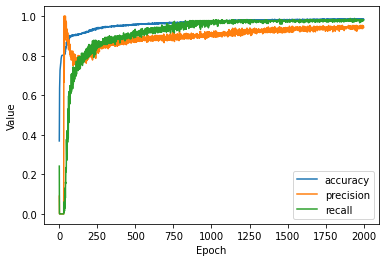

In [13]:
#@title Double-click to view the solution for Task 3.

# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 2000
batch_size = 500
label_name = "median_house_value_is_high"
classification_threshold = 0.4

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)
print('it took',time()-st,'sec')

# The new graphs suggest that precision and recall are 
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.

## Summarize model performance 

one more metric that attempts to summarize the model's overall performance. 

In [14]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 2ms/step - loss: 0.0613 - accuracy: 0.9807 - precision: 0.9112 - recall: 0.9958


[0.06127893552184105,
 0.9807383418083191,
 0.9111968874931335,
 0.9957805871963501]

Epoch 1/2000
Consider rewriting this model with the Functional API.


/home/vedant/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Consider rewriting this model with the Functional API.
28/28 [==============================] - 1s 896us/step - loss: 0.7062 - auc: 0.3528
Epoch 2/2000
28/28 [==============================] - 0s 948us/step - loss: 0.6682 - auc: 0.2407
Epoch 3/2000
28/28 [==============================] - 0s 935us/step - loss: 0.6448 - auc: 0.1875
Epoch 4/2000
28/28 [==============================] - 0s 884us/step - loss: 0.6304 - auc: 0.1462
Epoch 5/2000
28/28 [==============================] - 0s 911us/step - loss: 0.6226 - auc: 0.1252
Epoch 6/2000
28/28 [==============================] - 0s 974us/step - loss: 0.6171 - auc: 0.1163
Epoch 7/2000
28/28 [==============================] - 0s 972us/step - loss: 0.6125 - auc: 0.1156
Epoch 8/2000
28/28 [==============================] - 0s 926us/step - loss: 0.6083 - auc: 0.1128
Epoch 9/2000
28/28 [==============================] - 0s 882us/step - loss: 0.6044 - auc: 0.1175
Epoch 10/2000
28/28 [==============================] - 0s 996us/step - loss: 0.6008 -

28/28 [==============================] - 0s 989us/step - loss: 0.4290 - auc: 0.9526
Epoch 73/2000
28/28 [==============================] - 0s 901us/step - loss: 0.4271 - auc: 0.9537
Epoch 74/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.4254 - auc: 0.9536
Epoch 75/2000
28/28 [==============================] - 0s 943us/step - loss: 0.4235 - auc: 0.9576
Epoch 76/2000
28/28 [==============================] - 0s 948us/step - loss: 0.4217 - auc: 0.9568
Epoch 77/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.4198 - auc: 0.9579
Epoch 78/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.4179 - auc: 0.9585
Epoch 79/2000
28/28 [==============================] - 0s 982us/step - loss: 0.4161 - auc: 0.9612
Epoch 80/2000
28/28 [==============================] - 0s 969us/step - loss: 0.4142 - auc: 0.9618
Epoch 81/2000
28/28 [==============================] - 0s 996us/step - loss: 0.4124 - auc: 0.9626
Epoch 82/2000
28/28 [===================

28/28 [==============================] - 0s 1ms/step - loss: 0.3156 - auc: 0.9808
Epoch 157/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.3146 - auc: 0.9807
Epoch 158/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.3136 - auc: 0.9811
Epoch 159/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.3126 - auc: 0.9807
Epoch 160/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.3117 - auc: 0.9805
Epoch 161/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.3109 - auc: 0.9810
Epoch 162/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.3101 - auc: 0.9812
Epoch 163/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.3092 - auc: 0.9816
Epoch 164/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.3084 - auc: 0.9812
Epoch 165/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.3075 - auc: 0.9812
Epoch 166/2000
28/28 [=======================

Epoch 240/2000
28/28 [==============================] - 0s 888us/step - loss: 0.2600 - auc: 0.9837
Epoch 241/2000
28/28 [==============================] - 0s 898us/step - loss: 0.2595 - auc: 0.9843
Epoch 242/2000
28/28 [==============================] - 0s 963us/step - loss: 0.2591 - auc: 0.9842
Epoch 243/2000
28/28 [==============================] - 0s 886us/step - loss: 0.2586 - auc: 0.9842
Epoch 244/2000
28/28 [==============================] - 0s 899us/step - loss: 0.2581 - auc: 0.9841
Epoch 245/2000
28/28 [==============================] - 0s 890us/step - loss: 0.2577 - auc: 0.9839
Epoch 246/2000
28/28 [==============================] - 0s 918us/step - loss: 0.2574 - auc: 0.9838
Epoch 247/2000
28/28 [==============================] - 0s 933us/step - loss: 0.2569 - auc: 0.9841
Epoch 248/2000
28/28 [==============================] - 0s 938us/step - loss: 0.2565 - auc: 0.9839
Epoch 249/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.2560 - auc: 0.9840
Epoch 250/20

28/28 [==============================] - 0s 1ms/step - loss: 0.2288 - auc: 0.9862
Epoch 324/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.2285 - auc: 0.9861
Epoch 325/2000
28/28 [==============================] - 0s 960us/step - loss: 0.2282 - auc: 0.9862
Epoch 326/2000
28/28 [==============================] - 0s 947us/step - loss: 0.2279 - auc: 0.9862
Epoch 327/2000
28/28 [==============================] - 0s 961us/step - loss: 0.2276 - auc: 0.9862
Epoch 328/2000
28/28 [==============================] - 0s 955us/step - loss: 0.2273 - auc: 0.9861
Epoch 329/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.2271 - auc: 0.9863
Epoch 330/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.2267 - auc: 0.9863
Epoch 331/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.2265 - auc: 0.9864
Epoch 332/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.2261 - auc: 0.9865
Epoch 333/2000
28/28 [===============

28/28 [==============================] - 0s 947us/step - loss: 0.2073 - auc: 0.9879
Epoch 407/2000
28/28 [==============================] - 0s 970us/step - loss: 0.2070 - auc: 0.9880
Epoch 408/2000
28/28 [==============================] - 0s 932us/step - loss: 0.2066 - auc: 0.9881
Epoch 409/2000
28/28 [==============================] - 0s 948us/step - loss: 0.2066 - auc: 0.9881
Epoch 410/2000
28/28 [==============================] - 0s 947us/step - loss: 0.2064 - auc: 0.9881
Epoch 411/2000
28/28 [==============================] - 0s 887us/step - loss: 0.2061 - auc: 0.9881
Epoch 412/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.2060 - auc: 0.9880
Epoch 413/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.2057 - auc: 0.9882
Epoch 414/2000
28/28 [==============================] - 0s 857us/step - loss: 0.2056 - auc: 0.9881
Epoch 415/2000
28/28 [==============================] - 0s 945us/step - loss: 0.2054 - auc: 0.9882
Epoch 416/2000
28/28 [=======

28/28 [==============================] - 0s 885us/step - loss: 0.1914 - auc: 0.9895
Epoch 490/2000
28/28 [==============================] - 0s 939us/step - loss: 0.1913 - auc: 0.9896
Epoch 491/2000
28/28 [==============================] - 0s 935us/step - loss: 0.1912 - auc: 0.9897
Epoch 492/2000
28/28 [==============================] - 0s 946us/step - loss: 0.1910 - auc: 0.9897
Epoch 493/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1909 - auc: 0.9895
Epoch 494/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1907 - auc: 0.9896
Epoch 495/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1906 - auc: 0.9896
Epoch 496/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1904 - auc: 0.9896
Epoch 497/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1903 - auc: 0.9896
Epoch 498/2000
28/28 [==============================] - 0s 903us/step - loss: 0.1901 - auc: 0.9897
Epoch 499/2000
28/28 [=============

28/28 [==============================] - 0s 2ms/step - loss: 0.1792 - auc: 0.9905
Epoch 574/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1789 - auc: 0.9908
Epoch 575/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1789 - auc: 0.9908
Epoch 576/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1787 - auc: 0.9909
Epoch 577/2000
28/28 [==============================] - 0s 997us/step - loss: 0.1786 - auc: 0.9909
Epoch 578/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1785 - auc: 0.9909
Epoch 579/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1783 - auc: 0.9908
Epoch 580/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1782 - auc: 0.9909
Epoch 581/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1780 - auc: 0.9909
Epoch 582/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1779 - auc: 0.9910
Epoch 583/2000
28/28 [=====================

Epoch 657/2000
28/28 [==============================] - 0s 955us/step - loss: 0.1690 - auc: 0.9920
Epoch 658/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1689 - auc: 0.9920
Epoch 659/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1688 - auc: 0.9920
Epoch 660/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1688 - auc: 0.9920
Epoch 661/2000
28/28 [==============================] - 0s 943us/step - loss: 0.1686 - auc: 0.9919
Epoch 662/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1685 - auc: 0.9920
Epoch 663/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1684 - auc: 0.9919
Epoch 664/2000
28/28 [==============================] - 0s 869us/step - loss: 0.1683 - auc: 0.9921
Epoch 665/2000
28/28 [==============================] - 0s 2ms/step - loss: 0.1681 - auc: 0.9920
Epoch 666/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1681 - auc: 0.9920
Epoch 667/2000
28/28 [==

28/28 [==============================] - 0s 1ms/step - loss: 0.1606 - auc: 0.9927
Epoch 741/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1605 - auc: 0.9927
Epoch 742/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1604 - auc: 0.9928
Epoch 743/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1603 - auc: 0.9928
Epoch 744/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1602 - auc: 0.9927
Epoch 745/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1601 - auc: 0.9928
Epoch 746/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1600 - auc: 0.9929
Epoch 747/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1599 - auc: 0.9929
Epoch 748/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1598 - auc: 0.9928
Epoch 749/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1597 - auc: 0.9929
Epoch 750/2000
28/28 [=======================

28/28 [==============================] - 0s 1ms/step - loss: 0.1531 - auc: 0.9934
Epoch 825/2000
28/28 [==============================] - 0s 952us/step - loss: 0.1531 - auc: 0.9933
Epoch 826/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1529 - auc: 0.9935
Epoch 827/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1529 - auc: 0.9934
Epoch 828/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1528 - auc: 0.9936
Epoch 829/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1527 - auc: 0.9934
Epoch 830/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1527 - auc: 0.9934
Epoch 831/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1526 - auc: 0.9935
Epoch 832/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1525 - auc: 0.9935
Epoch 833/2000
28/28 [==============================] - 0s 874us/step - loss: 0.1525 - auc: 0.9935
Epoch 834/2000
28/28 [===================

28/28 [==============================] - 0s 934us/step - loss: 0.1468 - auc: 0.9940
Epoch 908/2000
28/28 [==============================] - 0s 998us/step - loss: 0.1467 - auc: 0.9941
Epoch 909/2000
28/28 [==============================] - 0s 916us/step - loss: 0.1466 - auc: 0.9940
Epoch 910/2000
28/28 [==============================] - 0s 913us/step - loss: 0.1465 - auc: 0.9940
Epoch 911/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1465 - auc: 0.9940
Epoch 912/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1465 - auc: 0.9941
Epoch 913/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1463 - auc: 0.9940
Epoch 914/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1463 - auc: 0.9940
Epoch 915/2000
28/28 [==============================] - 0s 898us/step - loss: 0.1462 - auc: 0.9941
Epoch 916/2000
28/28 [==============================] - 0s 958us/step - loss: 0.1461 - auc: 0.9941
Epoch 917/2000
28/28 [===========

28/28 [==============================] - 0s 1ms/step - loss: 0.1410 - auc: 0.9945
Epoch 991/2000
28/28 [==============================] - 0s 945us/step - loss: 0.1410 - auc: 0.9945
Epoch 992/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1409 - auc: 0.9945
Epoch 993/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1409 - auc: 0.9945
Epoch 994/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1408 - auc: 0.9945
Epoch 995/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1407 - auc: 0.9945
Epoch 996/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1407 - auc: 0.9945
Epoch 997/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1407 - auc: 0.9945
Epoch 998/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1406 - auc: 0.9945
Epoch 999/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1405 - auc: 0.9945
Epoch 1000/2000
28/28 [====================

28/28 [==============================] - 0s 1ms/step - loss: 0.1359 - auc: 0.9949
Epoch 1074/2000
28/28 [==============================] - 0s 879us/step - loss: 0.1357 - auc: 0.9949
Epoch 1075/2000
28/28 [==============================] - 0s 889us/step - loss: 0.1358 - auc: 0.9949
Epoch 1076/2000
28/28 [==============================] - 0s 875us/step - loss: 0.1359 - auc: 0.9949
Epoch 1077/2000
28/28 [==============================] - 0s 926us/step - loss: 0.1357 - auc: 0.9949
Epoch 1078/2000
28/28 [==============================] - 0s 904us/step - loss: 0.1357 - auc: 0.9949
Epoch 1079/2000
28/28 [==============================] - 0s 920us/step - loss: 0.1356 - auc: 0.9949
Epoch 1080/2000
28/28 [==============================] - 0s 903us/step - loss: 0.1355 - auc: 0.9949
Epoch 1081/2000
28/28 [==============================] - 0s 933us/step - loss: 0.1355 - auc: 0.9949
Epoch 1082/2000
28/28 [==============================] - 0s 910us/step - loss: 0.1354 - auc: 0.9950
Epoch 1083/2000
28

28/28 [==============================] - 0s 868us/step - loss: 0.1315 - auc: 0.9952
Epoch 1156/2000
28/28 [==============================] - 0s 898us/step - loss: 0.1314 - auc: 0.9953
Epoch 1157/2000
28/28 [==============================] - 0s 899us/step - loss: 0.1313 - auc: 0.9953
Epoch 1158/2000
28/28 [==============================] - 0s 890us/step - loss: 0.1313 - auc: 0.9954
Epoch 1159/2000
28/28 [==============================] - 0s 845us/step - loss: 0.1312 - auc: 0.9953
Epoch 1160/2000
28/28 [==============================] - 0s 879us/step - loss: 0.1312 - auc: 0.9953
Epoch 1161/2000
28/28 [==============================] - 0s 866us/step - loss: 0.1311 - auc: 0.9953
Epoch 1162/2000
28/28 [==============================] - 0s 853us/step - loss: 0.1311 - auc: 0.9953
Epoch 1163/2000
28/28 [==============================] - 0s 880us/step - loss: 0.1310 - auc: 0.9952
Epoch 1164/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1310 - auc: 0.9953
Epoch 1165/2000
28

28/28 [==============================] - 0s 956us/step - loss: 0.1273 - auc: 0.9956
Epoch 1239/2000
28/28 [==============================] - 0s 945us/step - loss: 0.1272 - auc: 0.9956
Epoch 1240/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1272 - auc: 0.9956
Epoch 1241/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1271 - auc: 0.9956
Epoch 1242/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1271 - auc: 0.9956
Epoch 1243/2000
28/28 [==============================] - 0s 979us/step - loss: 0.1270 - auc: 0.9956
Epoch 1244/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1270 - auc: 0.9956
Epoch 1245/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1269 - auc: 0.9956
Epoch 1246/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1269 - auc: 0.9956
Epoch 1247/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1268 - auc: 0.9956
Epoch 1248/2000
28/28 [=======

28/28 [==============================] - 0s 1ms/step - loss: 0.1235 - auc: 0.9959
Epoch 1322/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1234 - auc: 0.9959
Epoch 1323/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1234 - auc: 0.9959
Epoch 1324/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1233 - auc: 0.9959
Epoch 1325/2000
28/28 [==============================] - 0s 2ms/step - loss: 0.1233 - auc: 0.9959
Epoch 1326/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1233 - auc: 0.9959
Epoch 1327/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1233 - auc: 0.9959
Epoch 1328/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1231 - auc: 0.9959
Epoch 1329/2000
28/28 [==============================] - 0s 2ms/step - loss: 0.1231 - auc: 0.9958
Epoch 1330/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1231 - auc: 0.9959
Epoch 1331/2000
28/28 [=============

28/28 [==============================] - 0s 1ms/step - loss: 0.1200 - auc: 0.9961
Epoch 1405/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1200 - auc: 0.9961
Epoch 1406/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1200 - auc: 0.9961
Epoch 1407/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1199 - auc: 0.9961
Epoch 1408/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1199 - auc: 0.9961
Epoch 1409/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1199 - auc: 0.9962
Epoch 1410/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1198 - auc: 0.9962
Epoch 1411/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1197 - auc: 0.9961
Epoch 1412/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1197 - auc: 0.9961
Epoch 1413/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1197 - auc: 0.9962
Epoch 1414/2000
28/28 [=============

28/28 [==============================] - 0s 1ms/step - loss: 0.1168 - auc: 0.9963
Epoch 1488/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1169 - auc: 0.9963
Epoch 1489/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1168 - auc: 0.9963
Epoch 1490/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1168 - auc: 0.9963
Epoch 1491/2000
28/28 [==============================] - 0s 908us/step - loss: 0.1167 - auc: 0.9963
Epoch 1492/2000
28/28 [==============================] - 0s 972us/step - loss: 0.1167 - auc: 0.9964
Epoch 1493/2000
28/28 [==============================] - 0s 961us/step - loss: 0.1167 - auc: 0.9963
Epoch 1494/2000
28/28 [==============================] - 0s 937us/step - loss: 0.1166 - auc: 0.9964
Epoch 1495/2000
28/28 [==============================] - 0s 984us/step - loss: 0.1166 - auc: 0.9964
Epoch 1496/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1165 - auc: 0.9963
Epoch 1497/2000
28/28 [===

28/28 [==============================] - 0s 967us/step - loss: 0.1140 - auc: 0.9965
Epoch 1570/2000
28/28 [==============================] - 0s 982us/step - loss: 0.1139 - auc: 0.9965
Epoch 1571/2000
28/28 [==============================] - 0s 993us/step - loss: 0.1139 - auc: 0.9966
Epoch 1572/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1139 - auc: 0.9965
Epoch 1573/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1138 - auc: 0.9966
Epoch 1574/2000
28/28 [==============================] - 0s 844us/step - loss: 0.1138 - auc: 0.9965
Epoch 1575/2000
28/28 [==============================] - 0s 896us/step - loss: 0.1137 - auc: 0.9965
Epoch 1576/2000
28/28 [==============================] - 0s 915us/step - loss: 0.1137 - auc: 0.9966
Epoch 1577/2000
28/28 [==============================] - 0s 990us/step - loss: 0.1137 - auc: 0.9965
Epoch 1578/2000
28/28 [==============================] - 0s 986us/step - loss: 0.1136 - auc: 0.9966
Epoch 1579/2000
28/2

28/28 [==============================] - 0s 1ms/step - loss: 0.1112 - auc: 0.9967
Epoch 1653/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1111 - auc: 0.9967
Epoch 1654/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1111 - auc: 0.9967
Epoch 1655/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1111 - auc: 0.9967
Epoch 1656/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1110 - auc: 0.9967
Epoch 1657/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1110 - auc: 0.9967
Epoch 1658/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1110 - auc: 0.9968
Epoch 1659/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1110 - auc: 0.9967
Epoch 1660/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1109 - auc: 0.9967
Epoch 1661/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1109 - auc: 0.9968
Epoch 1662/2000
28/28 [=============

28/28 [==============================] - 0s 943us/step - loss: 0.1086 - auc: 0.9970
Epoch 1736/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1086 - auc: 0.9969
Epoch 1737/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1086 - auc: 0.9969
Epoch 1738/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1085 - auc: 0.9969
Epoch 1739/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1085 - auc: 0.9969
Epoch 1740/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1085 - auc: 0.9969
Epoch 1741/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1085 - auc: 0.9969
Epoch 1742/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1084 - auc: 0.9969
Epoch 1743/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1084 - auc: 0.9969
Epoch 1744/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1084 - auc: 0.9969
Epoch 1745/2000
28/28 [===========

28/28 [==============================] - 0s 1ms/step - loss: 0.1062 - auc: 0.9971
Epoch 1819/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1062 - auc: 0.9971
Epoch 1820/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1061 - auc: 0.9971
Epoch 1821/2000
28/28 [==============================] - 0s 854us/step - loss: 0.1061 - auc: 0.9971
Epoch 1822/2000
28/28 [==============================] - 0s 899us/step - loss: 0.1061 - auc: 0.9971
Epoch 1823/2000
28/28 [==============================] - 0s 907us/step - loss: 0.1060 - auc: 0.9971
Epoch 1824/2000
28/28 [==============================] - 0s 906us/step - loss: 0.1060 - auc: 0.9971
Epoch 1825/2000
28/28 [==============================] - 0s 898us/step - loss: 0.1060 - auc: 0.9972
Epoch 1826/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1060 - auc: 0.9971
Epoch 1827/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1059 - auc: 0.9970
Epoch 1828/2000
28/28 [===

28/28 [==============================] - 0s 1ms/step - loss: 0.1040 - auc: 0.9973
Epoch 1902/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1039 - auc: 0.9972
Epoch 1903/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1039 - auc: 0.9972
Epoch 1904/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1039 - auc: 0.9972
Epoch 1905/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1039 - auc: 0.9972
Epoch 1906/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1039 - auc: 0.9972
Epoch 1907/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1038 - auc: 0.9972
Epoch 1908/2000
28/28 [==============================] - 0s 1ms/step - loss: 0.1038 - auc: 0.9973
Epoch 1909/2000
28/28 [==============================] - 0s 981us/step - loss: 0.1038 - auc: 0.9972
Epoch 1910/2000
28/28 [==============================] - 0s 931us/step - loss: 0.1037 - auc: 0.9973
Epoch 1911/2000
28/28 [=========

28/28 [==============================] - 0s 961us/step - loss: 0.1019 - auc: 0.9973
Epoch 1984/2000
28/28 [==============================] - 0s 986us/step - loss: 0.1019 - auc: 0.9974
Epoch 1985/2000
28/28 [==============================] - 0s 956us/step - loss: 0.1018 - auc: 0.9974
Epoch 1986/2000
28/28 [==============================] - 0s 987us/step - loss: 0.1018 - auc: 0.9973
Epoch 1987/2000
28/28 [==============================] - 0s 945us/step - loss: 0.1018 - auc: 0.9974
Epoch 1988/2000
28/28 [==============================] - 0s 960us/step - loss: 0.1017 - auc: 0.9974
Epoch 1989/2000
28/28 [==============================] - 0s 942us/step - loss: 0.1018 - auc: 0.9974
Epoch 1990/2000
28/28 [==============================] - 0s 954us/step - loss: 0.1017 - auc: 0.9974
Epoch 1991/2000
28/28 [==============================] - 0s 951us/step - loss: 0.1017 - auc: 0.9974
Epoch 1992/2000
28/28 [==============================] - 0s 928us/step - loss: 0.1017 - auc: 0.9974
Epoch 1993/2000


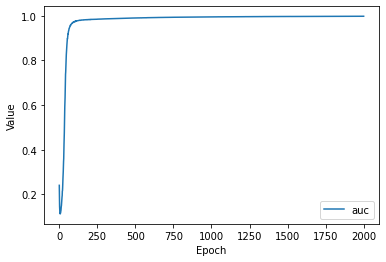

In [15]:
#@title Double-click to view the solution for Task 5.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 2000
batch_size = 50
label_name = "median_house_value_is_high"
classification_threshold = 0.4

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)